<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/Youssef%20O/%2001.3%20-%20GradCAM_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load data saved in Google drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the .zip file.

In [2]:
!unzip -q "/content/drive/MyDrive/Github/Assessment 2/MRI Brain Data.zip" -d "/content/data"



Import dataloaders and create our test and train datasets using various standard data augmentations such as random rotations, normalisation and resizing our image to be $224 \times 224$.

In [3]:
# Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
# Preprocessing


train_transform = transforms.Compose([
    # Data Augmentation
    transforms.RandomRotation(degrees=15),

    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# No Data Augmentation
train_dataset_simple = datasets.ImageFolder("/content/data/Training", transform=test_transform)
test_dataset_simple = datasets.ImageFolder("/content/data/Testing",  transform=test_transform)

# Augmentation for training dataset
train_dataset = datasets.ImageFolder("/content/data/Training", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/data/Testing",  transform=test_transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

View the classes of the output.

In [5]:
train_dataset.classes


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

View the dimensions of the images.

In [6]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)


torch.Size([64, 3, 224, 224]) torch.Size([64])


# Grad-CAM CNN:

In order to interpret the inner works of the Grad-CAM interpretation method, we make a model convolutional neural network that is different to the one described in the previous chapters. This is for the sake of interpretability, as the CNN described in the previous section has $256$ channels in it's last convolutional layer. The model we train in this notebook has $128$ which makes it much more interpretable for viewing the feature maps as the features are of larger dimensions.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GradCAM_CNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # ---- 1st conv block ----
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)   # 256 → 128

        # ---- 2nd conv block ----
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)   # 128 → 64

        # ---- 3rd conv block (last conv, used for GradCAM) ----
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)   # 64 → 32

        # ---- Fully connected classifier ----
        self.fc1 = nn.Linear(128 * 28 * 28, 128)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        self.feature_maps = x            # store for GradCAM
        x = self.pool3(x)

        x = x.view(x.size(0), -1)        # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


We use the cross entropy loss function and the Adam optimiser. We also use the google colab built in GPU in order to speed up the training time.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GradCAM_CNN(num_classes=len(train_dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


We train the model for 50 Epochs and track the loss/accuracy metrics.

In [9]:
import json
import time
import os
import torch
import torch.nn as nn


# Helper: Count parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters())


# Checkpoint directory
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_loss = float("inf")
best_model_path = os.path.join(checkpoint_dir, "best_model.pth")


# Track metrics for JSON output
history = {
    "training_loss": [],
    "training_accuracy": [],
    "validation_loss": [],
    "validation_accuracy": []
}


# Training loop
EPOCHS = 50
start_time = time.time()

for epoch in range(EPOCHS):

    # TRAINING
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    #VALIDATION
    model.eval()
    val_loss_running = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss_running += loss.item()
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_loss_running / len(test_loader)
    val_acc = val_correct / val_total

    # Save metrics
    history["training_loss"].append(train_loss)
    history["training_accuracy"].append(train_acc)
    history["validation_loss"].append(val_loss)
    history["validation_accuracy"].append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # ===== Checkpoint: Save best model =====
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved better model → {best_model_path}")


# Training completed

end_time = time.time()
training_time = end_time - start_time


model.eval()
test_loss_running = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss_running += loss.item()
        _, preds = outputs.max(1)
        test_total += labels.size(0)
        test_correct += (preds == labels).sum().item()

test_loss = test_loss_running / len(test_loader)
test_acc = test_correct / test_total



# Build JSON results dictionary
results = {
    "training_loss": history["training_loss"],
    "training_accuracy": history["training_accuracy"],
    "validation_loss": history["validation_loss"],
    "validation_accuracy": history["validation_accuracy"],
    "training_time_seconds": training_time,
    "model_params": {
        "num_conv_layers": 3,
        "filter_base": 32,
        "dense_units": 128,
        "IMG_SIZE": 256,
        "num_classes": len(train_dataset.classes),
        "total_parameters": count_params(model)
    },
    "test_loss": test_loss,
    "test_accuracy": test_acc
}

# Save JSON
with open("model_training_results.json", "w") as f:
    json.dump(results, f, indent=4)

print(f"\nFINAL TEST RESULTS → Loss: {test_loss:.4f},  Accuracy: {test_acc:.4f}")
print("Training results saved to model_training_results.json")


Epoch [1/50] Train Loss: 0.9979 | Train Acc: 58.54% | Val Loss: 2.7284 | Val Acc: 33.76%
Saved better model → checkpoints/best_model.pth
Epoch [2/50] Train Loss: 0.6825 | Train Acc: 71.78% | Val Loss: 2.9376 | Val Acc: 46.45%
Epoch [3/50] Train Loss: 0.5889 | Train Acc: 76.72% | Val Loss: 2.7488 | Val Acc: 47.46%
Epoch [4/50] Train Loss: 0.5224 | Train Acc: 79.55% | Val Loss: 3.1662 | Val Acc: 52.28%
Epoch [5/50] Train Loss: 0.4701 | Train Acc: 81.74% | Val Loss: 2.7492 | Val Acc: 56.85%
Epoch [6/50] Train Loss: 0.4356 | Train Acc: 83.52% | Val Loss: 3.0378 | Val Acc: 56.60%
Epoch [7/50] Train Loss: 0.3808 | Train Acc: 85.23% | Val Loss: 3.2641 | Val Acc: 56.85%
Epoch [8/50] Train Loss: 0.3577 | Train Acc: 86.48% | Val Loss: 3.0890 | Val Acc: 64.21%
Epoch [9/50] Train Loss: 0.3348 | Train Acc: 86.52% | Val Loss: 3.0213 | Val Acc: 63.71%
Epoch [10/50] Train Loss: 0.2810 | Train Acc: 89.62% | Val Loss: 3.2796 | Val Acc: 64.72%
Epoch [11/50] Train Loss: 0.2476 | Train Acc: 90.87% | Val Lo

# Grad-CAM in Practice
For the sake of this tutorial, we focus on a single explainer image to demonstrate the Grad-CAM interpretation method.

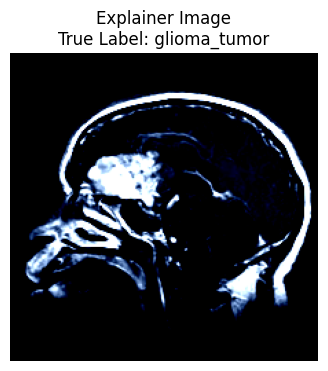

Image dimensions: torch.Size([3, 224, 224])
Predicted Label: no_tumor


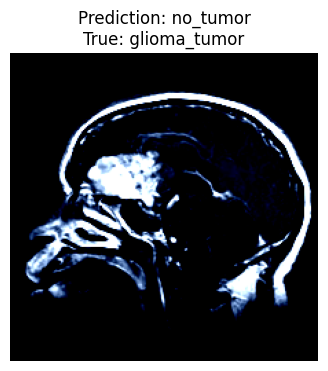

Feature map size: torch.Size([128, 56, 56])


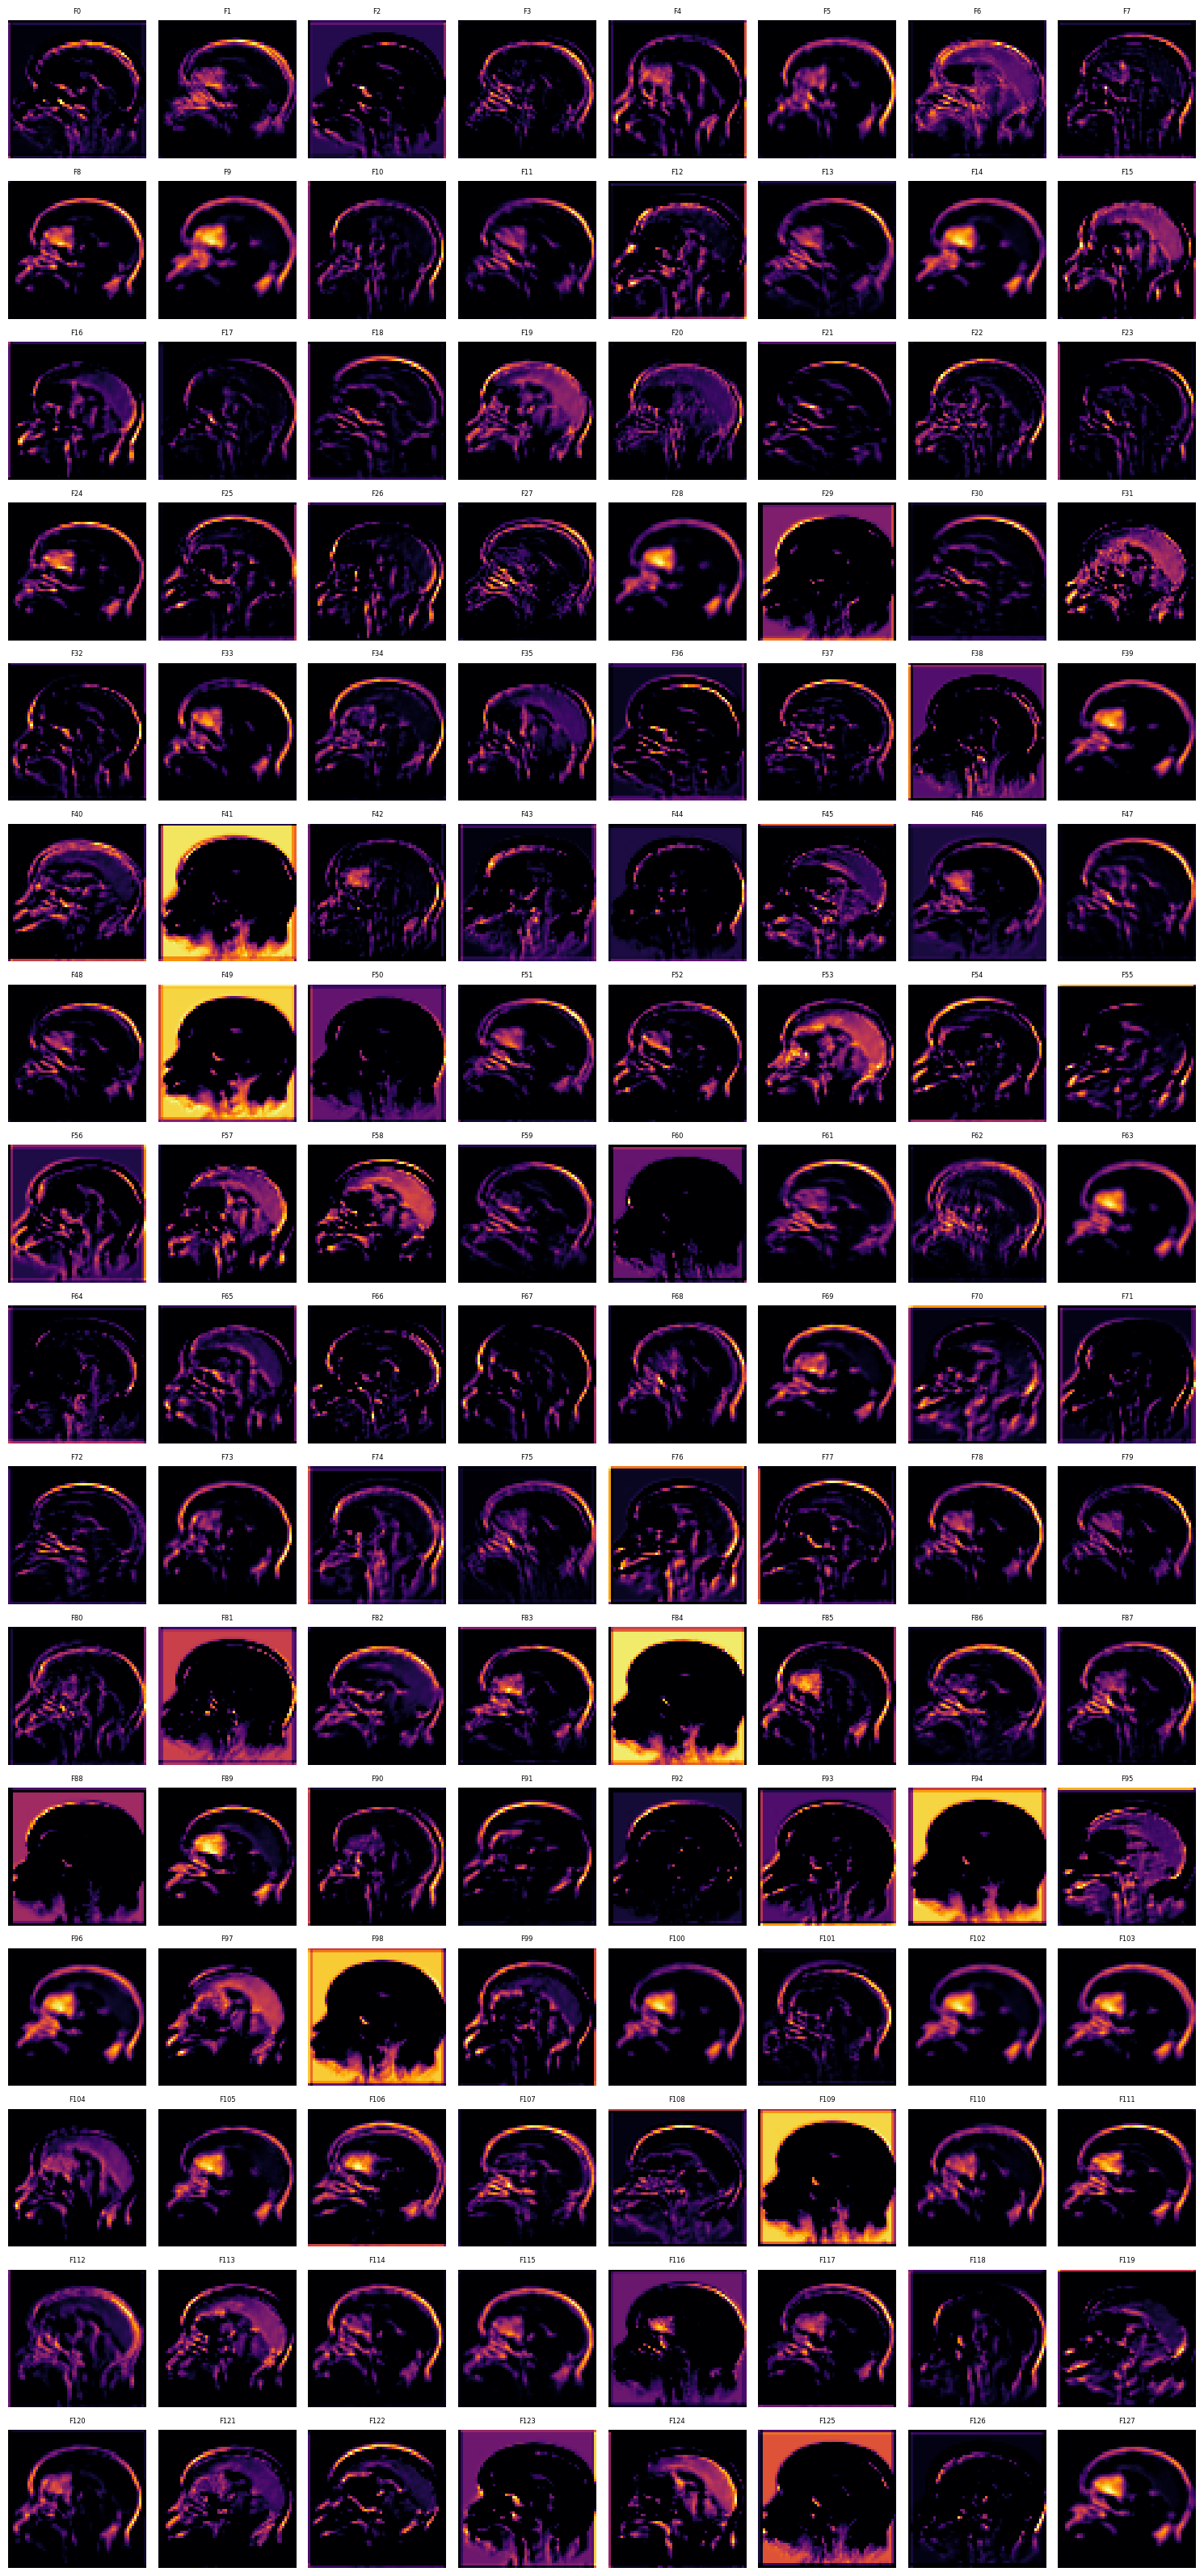

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Get a single explainer image
model.eval()
explainer_image, explainer_label = next(iter(test_loader))
explainer_image = explainer_image[1]        # take second image in batch
explainer_label = explainer_label[1].item()

explainer_image_device = explainer_image.unsqueeze(0).to(device)

class_names = train_dataset.classes

# Show the explainer image
plt.figure(figsize=(4,4))
plt.imshow(explainer_image.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Explainer Image\nTrue Label: {class_names[explainer_label]}")
plt.show()

print("Image dimensions:", explainer_image.shape)

#Model prediction

with torch.no_grad():
    output = model(explainer_image_device)
    _, pred_class = torch.max(output, 1)
    pred_class = pred_class.item()

print("Predicted Label:", class_names[pred_class])

plt.figure(figsize=(4,4))
plt.imshow(explainer_image.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Prediction: {class_names[pred_class]}\nTrue: {class_names[explainer_label]}")
plt.show()


#  Extract last convolutional layer activations
feature_maps = model.feature_maps[0].detach().cpu()   # shape: (32, 28, 28)
print("Feature map size:", feature_maps.shape)

num_features = feature_maps.shape[0]
cols = 8
rows = int(np.ceil(num_features / cols))

plt.figure(figsize=(15, rows * 2))

for i in range(num_features):
    fmap = feature_maps[i]
    fmap = (fmap - fmap.min()) / (fmap.max() + 1e-6)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(fmap, cmap='inferno')
    plt.axis("off")
    plt.title(f"F{i}", fontsize=6)

plt.tight_layout()
plt.show()



The input image is an image od size $224 \times 224$ and is of an image of a patient with a glioma tumor. The CNN model has predicted it as -- this not the correct label but since this is for explanation purposes we move on.

For this CNN model, we have 128 feature maps for our 128 channels. Each feature map is of dimension $56 \times 56$, and shows a convoluted version of the image, with each feature map showing activations for different features. For example, looking at the last row of feature maps (F120-F127), we can speculate that F120 looks more specifically at the outline of the skull and the whole tumor, whilst F124 is activated at the same areas but the area inside the brain seperate from the tumor is also activated this feature may be encoding the 'texture' of the brain as a predictor instead of just what shapes exist in the picture.

# Visualing the class activation gradient

We make a function which takes as input the image as a tensor, the class we want to investigate and then we look at the gradient at each pixel determining whether the model thinks that particular pixel is relevant in determining if feature map $k$ is in class $c$.

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def visualize_featuremap_gradient(model, image_tensor, k, class_index):
    """
    model: trained CNN (GradCAM_CNN)
    image_tensor: input image of shape (1, 3, 224, 224)
    k: index of feature map channel
    class_index: target class (int)

    Outputs:
    - logits: model output scores before softmax
    - score: logit for the target class
    - fmap: feature map A^k
    - grad: gradient ∂y_c/∂A^k
    - overlay: gradient × feature map
    """

    model.eval()
    image_tensor = image_tensor.to(device)
    image_tensor.requires_grad = True

    #  Forward pass
    outputs = model(image_tensor)
    logits = outputs[0]

    print("Logits (scores before softmax):")
    print(logits.detach().cpu().numpy())
    print(f"Logit for class {class_index}: {logits[class_index].item()}")

    score = logits[class_index]

    # retain gradient at feature maps
    model.feature_maps.retain_grad()

    #  Backprop
    model.zero_grad()
    score.backward(retain_graph=True)

    #  Extract feature map
    fmap = model.feature_maps[0, k].detach().cpu().numpy()

    # Extract gradient map
    grad = model.feature_maps.grad[0, k].detach().cpu().numpy()

    print(f"\nFeature map shape: {fmap.shape}")
    print(f"Gradient map shape: {grad.shape}")

    # Normalize feature map for display
    fmap_norm = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-6)


    grad_vis = grad  # keep original values for colorbar

    # Normalize for creating overlay only
    grad_norm = (grad - grad.min()) / (grad.max() - grad.min() + 1e-6)

    heatmap = plt.cm.jet(grad_norm)[..., :3]
    overlay = 0.5 * heatmap + 0.5 * np.stack([fmap_norm]*3, axis=-1)

    # Plot everything
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))

    # Feature map
    ax[0].imshow(fmap_norm, cmap="gray")
    ax[0].set_title(f"Feature Map k={k}")
    ax[0].axis("off")

    #  Gradient map
    im_grad = ax[1].imshow(grad_vis, cmap="jet")
    ax[1].set_title(f"Gradient ∂y_c/∂A^k for class {class_index}")
    ax[1].axis("off")

    # Add colourbar underneath gradient map
    cbar1 = fig.colorbar(im_grad, ax=ax[1], fraction=0.046, pad=0.04)
    cbar1.set_label("Gradient value\n(negative → decreases score,\npositive → increases score)", fontsize=8)

    # Overlay
    im_overlay = ax[2].imshow(overlay)
    ax[2].set_title("Overlay (gradient × feature map)")
    ax[2].axis("off")

    # Add colourbar underneath overlay (same gradient scale)
    cbar2 = fig.colorbar(im_grad, ax=ax[2], fraction=0.046, pad=0.04)
    cbar2.set_label("Gradient influence on feature map", fontsize=8)

    plt.show()

    return logits.detach(), fmap, grad



Logits (scores before softmax):
[-16.860392    0.6832495   1.5582024 -31.65452  ]
Logit for class 2: 1.5582023859024048

Feature map shape: (56, 56)
Gradient map shape: (56, 56)


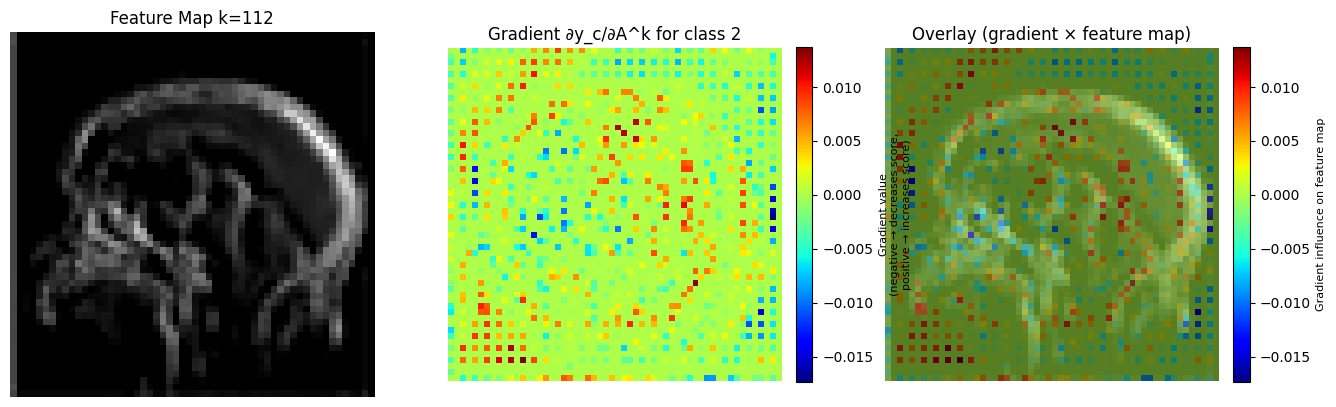

In [12]:
image = explainer_image.unsqueeze(0)
k = 112
c = 2

logits, fmap, grad = visualize_featuremap_gradient(model, image, k, c)

Note that here the gradient can be negative as we have not yet applied the ReLU activation function. If we choose deliberately incorrect labels such as the picture of a patient with a tumor and we choose to look at the activation of the 'no tumor' class we would see a larger negative gradient distribution in the image and this shows the utility of the Grad-CAM as a class of explainable AI (X-AI).

## Top $n$ relevant channels

The following function ranks the top $n$ most relevant channels in terms of their importance weights $\alpha_k$. Then outputs the importance weight of each channel, the feature map of each channel, the gradient map of each channel $k$ and then finally the weighted linear combination of all the feature maps.

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def rank_channel_importance(model, image_tensor, class_index, top_n=5):
    """
    inputs:
    model: trained CNN (GradCAM_CNN)
    image_tensor: input image of shape (1, 3, 224, 224)
    class_index: target class (int)

    Computes channel importance α_k, ranks channels, visualizes top-n,
    and returns the combined weighted feature map before ReLU.
    """

    model.eval()
    image_tensor = image_tensor.to(device)
    image_tensor.requires_grad = True

    # Forward pass
    output = model(image_tensor)
    logits = output[0]
    print("Logits:", logits.detach().cpu().numpy())

    score = logits[class_index]

    # Retain gradient for intermediate feature maps
    model.feature_maps.retain_grad()

    # Backprop for class score
    model.zero_grad()
    score.backward(retain_graph=True)

    # Extract feature maps A^k and gradients dS/dA^k
    fmap = model.feature_maps.detach().cpu()[0]      # shape (C,H,W)
    grad = model.feature_maps.grad.detach().cpu()[0] # shape (C,H,W)

    C, H, W = fmap.shape

    # Compute α_k importance for each channel
    alpha = grad.view(C, -1).mean(dim=1)   # mean gradient per channel
    alpha_np = alpha.numpy()

    # Rank channels by absolute importance
    sorted_idx = np.argsort(-np.abs(alpha_np))

    print("\nTop-n important channels (ranked by |αₖ|):")
    for i in range(top_n):
        k = sorted_idx[i]
        print(f"Rank {i+1}: Channel {k} | weight α_k = {alpha_np[k]:.4f}")

    # PLOT TOP-N IMPORTANT CHANNELS
    fig, axs = plt.subplots(top_n, 3, figsize=(10, 3*top_n))
    if top_n == 1:
        axs = np.expand_dims(axs, 0)

    for rank in range(top_n):
        k = sorted_idx[rank]

        fmap_k = fmap[k].numpy()
        grad_k = grad[k].numpy()

        # Normalize for visualization
        fmap_norm = (fmap_k - fmap_k.min()) / (fmap_k.max() - fmap_k.min() + 1e-6)
        grad_norm = (grad_k - grad_k.min()) / (grad_k.max() - grad_k.min() + 1e-6)

        axs[rank, 0].imshow(fmap_norm, cmap='gray')
        axs[rank, 0].set_title(f"Feature Map k={k}")
        axs[rank, 0].axis("off")

        im1 = axs[rank, 1].imshow(grad_norm, cmap='jet')
        axs[rank, 1].set_title(f"Gradient Map k={k}\nα={alpha_np[k]:.4f}")
        axs[rank, 1].axis("off")

        # Weighted feature map α_k * A^k
        weighted = alpha_np[k] * fmap_k
        weighted_norm = (weighted - weighted.min()) / (weighted.max() - weighted.min() + 1e-6)

        axs[rank, 2].imshow(weighted_norm, cmap='inferno')
        axs[rank, 2].set_title("αₖ A^k")
        axs[rank, 2].axis("off")

    plt.tight_layout()
    plt.show()

    #Compute Combined Weighted Feature Map (pre-ReLU CAM)
    weighted_sum = (alpha_np.reshape(-1,1,1) * fmap.numpy()).sum(axis=0)

    # Normalize for display
    weighted_sum_norm = (weighted_sum - weighted_sum.min()) / (weighted_sum.max() - weighted_sum.min() + 1e-6)

    # Plot CAM before ReLU
    plt.figure(figsize=(5,5))
    plt.imshow(weighted_sum_norm, cmap="inferno")
    plt.title("Linearly Combined Weighted Feature Map\n(CAM Pre-ReLU)")
    plt.axis("off")
    plt.colorbar()
    plt.show()

    # Return values
    return {
        "alpha": alpha_np,
        "importance_order": sorted_idx,
        "fmap": fmap.numpy(),
        "grad": grad.numpy(),
        "cam_pre_relu": weighted_sum,
    }


Logits: [-16.860392    0.6832495   1.5582024 -31.65452  ]

Top-n important channels (ranked by |αₖ|):
Rank 1: Channel 124 | weight α_k = -0.0005
Rank 2: Channel 102 | weight α_k = 0.0005
Rank 3: Channel 63 | weight α_k = 0.0004
Rank 4: Channel 9 | weight α_k = 0.0004
Rank 5: Channel 39 | weight α_k = 0.0004


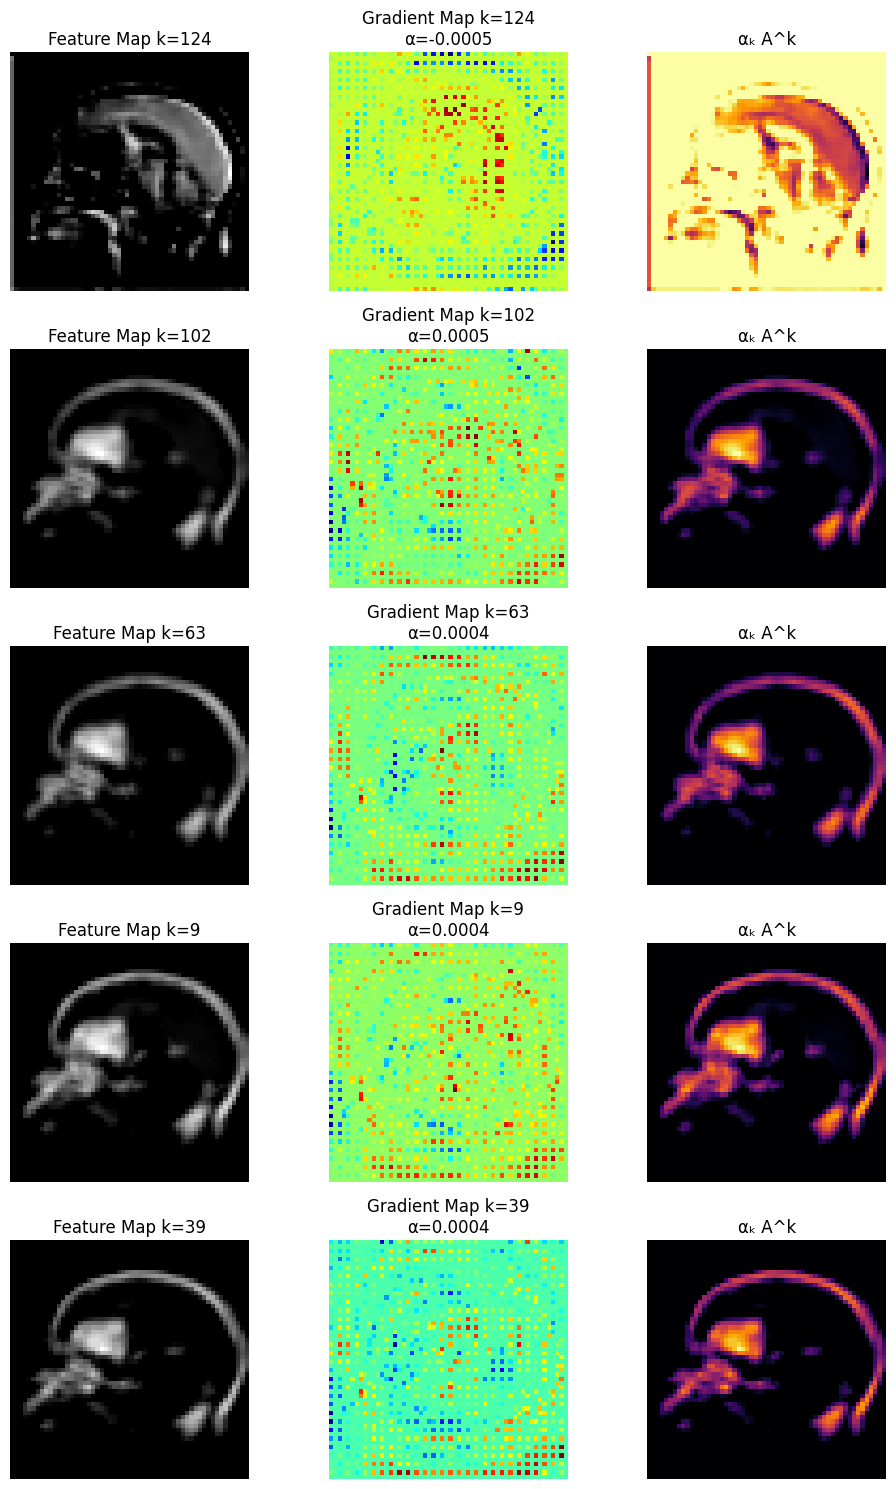

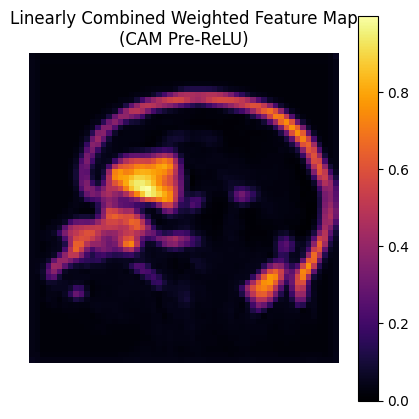

In [14]:
image = explainer_image.unsqueeze(0)   # (1,3,224,224)
class_index = 2
top_n = 5

results = rank_channel_importance(model, image, class_index, top_n)


## Filtering for postive class activation with ReLU:
Now that we have our class activation map, we create a function to filter out negative activations as we only want to see what parts the model is 'looking at' when it associates an image with a certain class. Therefore, we create a function that outputs the CAM before ReLU is applied and after the ReLU is applied and overlay these images onto a downsampled MRI image so that we can understand where these activations are happening and compare the pre-ReLU CAM and the post-ReLU CAM.

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


def compute_and_overlay_CAM(model, image_tensor, class_index):
    """
    inputs:
    model: trained CNN (GradCAM_CNN)
    image_tensor: input image of shape (1, 3, 224, 224)
    class_index: target class (int)

    Outputs:
    - cam_pre: CAM before ReLU
    - cam_post: CAM after ReLU
    - cam_pre_overlay: overlay of CAM pre-ReLU on downsampled MRI
    - cam_post_overlay: overlay of CAM post-ReLU on downsampled MRI
    - alpha: channel importance weights
    """

    model.eval()
    image_tensor = image_tensor.to(device)
    image_tensor.requires_grad = True

    # Forward pass
    output = model(image_tensor)
    logits = output[0]
    score = logits[class_index]

    # Retain feature map gradients
    model.feature_maps.retain_grad()

    # Backprop
    model.zero_grad()
    score.backward(retain_graph=True)

    fmap = model.feature_maps.detach().cpu()[0]          # (C,H,W)
    grad = model.feature_maps.grad.detach().cpu()[0]     # (C,H,W)

    C, H, W = fmap.shape

    # Compute alpha_k
    alpha = grad.view(C, -1).mean(dim=1).numpy()     # (C,)

    # Compute CAM_preReLU
    fmap_np = fmap.numpy()
    cam_pre = (alpha.reshape(-1, 1, 1) * fmap_np).sum(axis=0)   # (H,W)

    # Compute CAM_postReLU
    cam_post = np.maximum(cam_pre, 0)

    #  Downsample original MRI to the same size (H×W)
    mri = image_tensor[0].detach().cpu().numpy().transpose(1, 2, 0)  # (H_orig,W_orig,3)
    mri_torch = image_tensor.clone()

    # Resize to (1,3,H,W)
    mri_down = F.interpolate(mri_torch, size=(H, W), mode='bilinear', align_corners=False)
    mri_down = mri_down[0].detach().cpu().numpy().transpose(1, 2, 0)  # (H,W,3)

    # Normalize for visualization
    mri_down_norm = (mri_down - mri_down.min()) / (mri_down.max() - mri_down.min() + 1e-6)

    #Normalize CAMs for visualization
    def normalize(x):
        return (x - x.min()) / (x.max() - x.min() + 1e-6)

    cam_pre_norm = normalize(cam_pre)
    cam_post_norm = normalize(cam_post)

    heat_pre = plt.cm.jet(cam_pre_norm)[..., :3]
    heat_post = plt.cm.jet(cam_post_norm)[..., :3]

    overlay_pre = 0.6 * heat_pre + 0.4 * mri_down_norm
    overlay_post = 0.6 * heat_post + 0.4 * mri_down_norm

    # ---- 8. Plot results ----
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))

    # Downsampled MRI
    ax[0, 0].imshow(mri_down_norm)
    ax[0, 0].set_title("Downsampled MRI (28×28)")
    ax[0, 0].axis("off")

    # Pre-ReLU CAM (raw)
    ax[0, 1].imshow(cam_pre_norm, cmap='jet')
    ax[0, 1].set_title("CAM Pre-ReLU")
    ax[0, 1].axis("off")
    fig.colorbar(ax[0, 1].images[0], ax=ax[0, 1], fraction=0.046, pad=0.04)

    # Overlay Pre-ReLU CAM
    ax[0, 2].imshow(overlay_pre)
    ax[0, 2].set_title("Overlay: Pre-ReLU CAM")
    ax[0, 2].axis("off")

    # Post-ReLU CAM
    ax[1, 1].imshow(cam_post_norm, cmap='jet')
    ax[1, 1].set_title("CAM Post-ReLU")
    ax[1, 1].axis("off")
    fig.colorbar(ax[1, 1].images[0], ax=ax[1, 1], fraction=0.046, pad=0.04)

    # Overlay Post-ReLU CAM
    ax[1, 2].imshow(overlay_post)
    ax[1, 2].set_title("Overlay: Post-ReLU CAM")
    ax[1, 2].axis("off")

    # Hide empty subplot
    ax[1, 0].axis("off")

    plt.tight_layout()
    plt.show()

    return {
        "cam_pre": cam_pre,
        "cam_post": cam_post,
        "cam_pre_overlay": overlay_pre,
        "cam_post_overlay": overlay_post,
        "alpha": alpha
    }


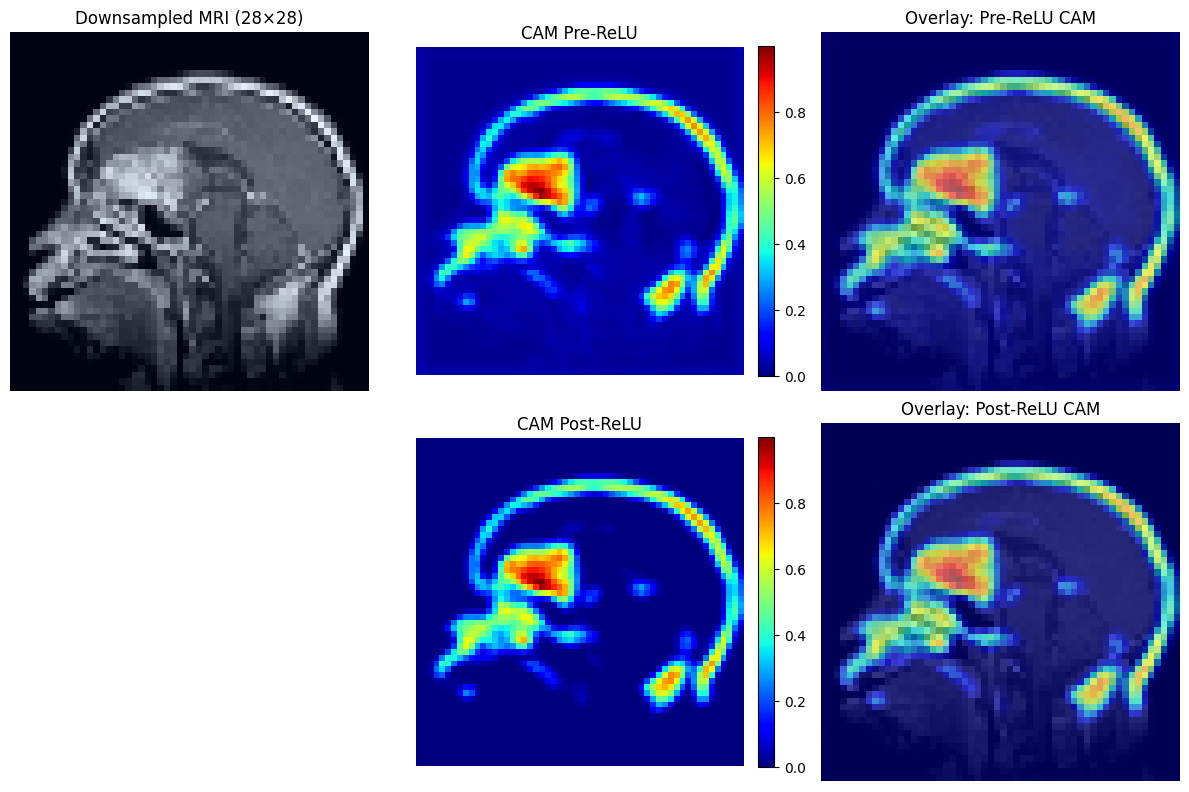

In [16]:
image = explainer_image.unsqueeze(0)   # (1,3,224,224)
c = 2

results = compute_and_overlay_CAM(model, image, c)


## Upsampling the CAM using bilinear interpolation:

Here we take the post-ReLU CAM and upsample the PyTorch function `interpolate` to upsample the CAM so that it is the same size as the input image. This then allows us to overlay the CAM heatmap over the oringal input MRI image.

In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


def upsample_and_overlay_CAM(model, image_tensor, cam_post):
    """
    Upsamples a post-ReLU CAM using bilinear interpolation
    and overlays it on the full-resolution MRI image.
    """

    # Original image (1,3,224,224)
    image_tensor = image_tensor.to(device)

    # Convert post-relu CAM (H,W) → torch tensor (1,1,H,W)
    cam_post_t = torch.tensor(cam_post, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Upsample to match the MRI resolution using bilinear interpolation
    upsampled = F.interpolate(cam_post_t, size=image_tensor.shape[-2:], mode='bilinear', align_corners=False)

    upsampled_cam = upsampled[0, 0].detach().cpu().numpy()

    # Normalize for visualization
    cam_up_norm = (upsampled_cam - upsampled_cam.min()) / (upsampled_cam.max() - upsampled_cam.min() + 1e-6)

    # Prepare original MRI for visualization
    mri = image_tensor[0].detach().cpu().numpy().transpose(1, 2, 0)
    mri_norm = (mri - mri.min()) / (mri.max() - mri.min() + 1e-6)

    # Create heatmap overlay
    heat = plt.cm.jet(cam_up_norm)[..., :3]
    overlay = 0.6 * heat + 0.4 * mri_norm

    # ---- Plot results ----
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original post-ReLU CAM (28×28)
    ax[0].imshow(cam_post, cmap='jet')
    ax[0].set_title("Original Post-ReLU CAM (28×28)")
    ax[0].axis("off")

    # Upsampled CAM (224×224)
    ax[1].imshow(cam_up_norm, cmap='jet')
    ax[1].set_title("Upsampled CAM (Bilinear, 224×224)")
    ax[1].axis("off")

    # Overlay
    ax[2].imshow(overlay)
    ax[2].set_title("Overlay: Upsampled CAM + MRI")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

    return cam_up_norm, overlay


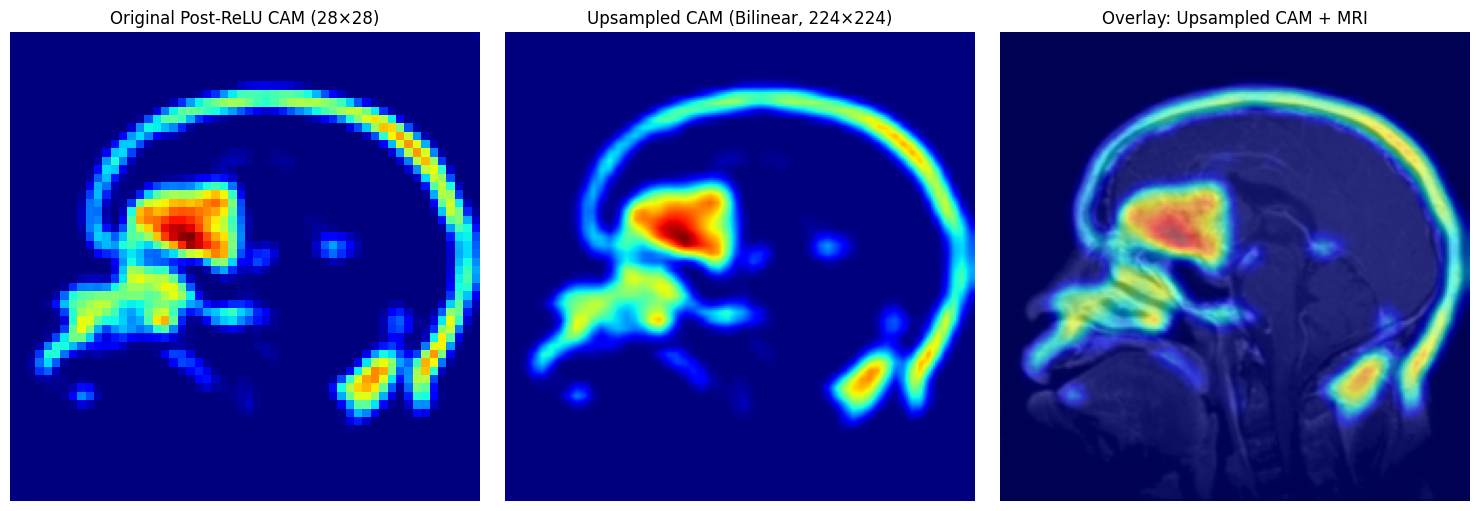

In [32]:
class_index = 2
image = explainer_image.unsqueeze(0)

cam_post = results["cam_post"]    # 28×28 post-ReLU CAM

cam_up, overlay = upsample_and_overlay_CAM(model, image, cam_post)


As we can see, the bilinear interpolation method prodcues a smooth output without any rough pixelated edges. After this is overlayed onto the original MRI, this produces a clean output with clear textures and edges visible.

### Using PyTorch Grad-CAM

Now we take our toy Grad-CAM functions and compare it with the function made by PyTorch available in this github.

In [33]:
!pip -q install grad-cam


We initialise our GradCAM class.

In [20]:

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


target_layer = model.conv3


cam = GradCAM(model=model,
              target_layers=[target_layer])


We then implement our new pre-designed Grad-CAM function onto the explainer image.

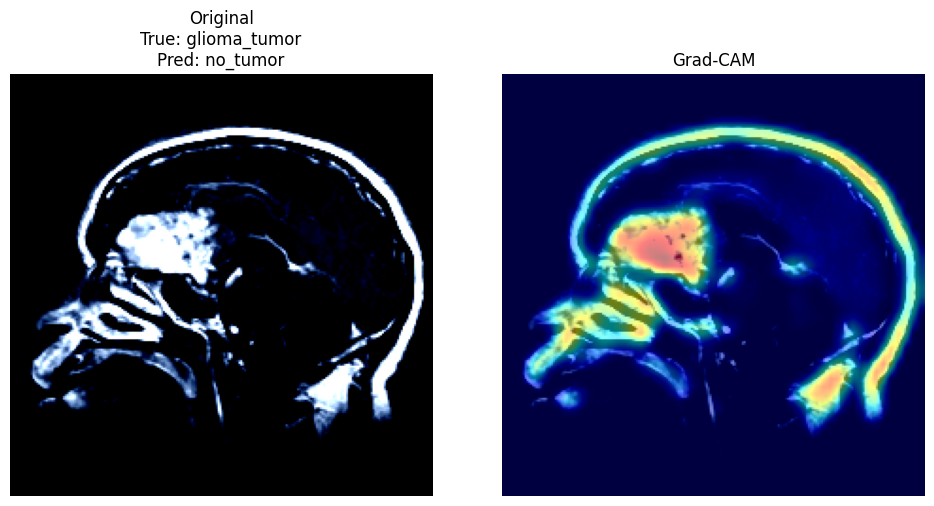

In [21]:
import cv2

# Get explainer imaage from test set

model.eval()
images, labels = next(iter(test_loader))

image = images[1].to(device)         # shape (3,224,224)
label = labels[1]


# Make prediction
with torch.no_grad():
    output = model(image.unsqueeze(0))
    _, pred = torch.max(output, 1)


# Create GradCAM heatmap
input_tensor = image.unsqueeze(0)  # shape (1,3,224,224)
target = [ClassifierOutputTarget(pred.item())]

grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0]

# Convert tensor image → numpy RGB image (0-1)
img = images[1].permute(1, 2, 0).cpu().numpy()
img = np.clip(img, 0, 1)

# Ensure CAM is numpy float32
grayscale_cam = grayscale_cam.astype(np.float32)

# Overlay
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)


# Plot GradCAM visualization

class_names = train_dataset.classes
true_label = class_names[label.item()]
pred_label = class_names[pred.item()]

plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f"Original\nTrue: {true_label}\nPred: {pred_label}")

# Heatmap
plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.axis('off')
plt.title("Grad-CAM")

plt.tight_layout()
plt.show()


Finally, we compare our orignial Grad-CAM function with the class available in PyTorch.

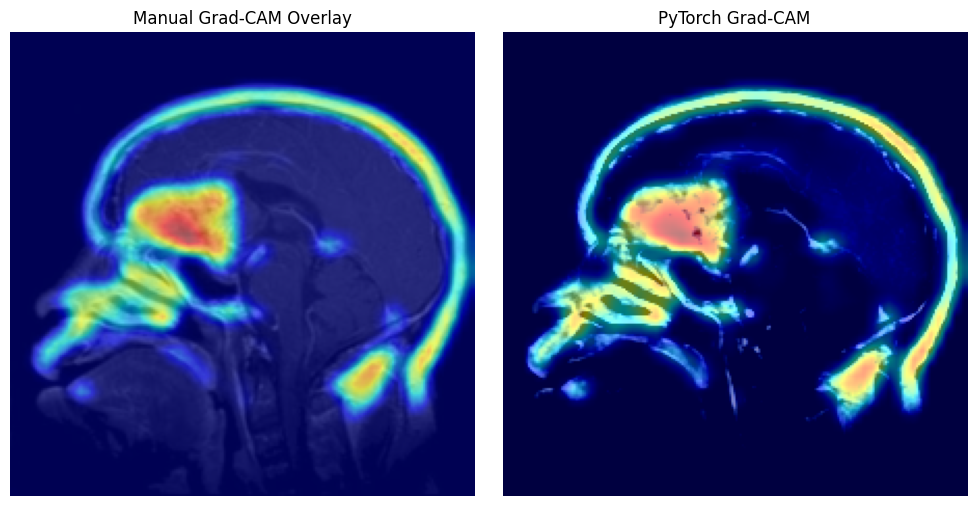

In [22]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(overlay)
plt.title("Manual Grad-CAM Overlay")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title("PyTorch Grad-CAM")
plt.axis("off")

plt.tight_layout()
plt.show()


We can see that both functions have near identical outputs, with the most important similarities being in the regions where there are activation are in the exact same place. The PyTorch function has a slightly clearer output in terms of the contrast in the colours. Moving forward we will use the PyTorch Grad-CAM function due to it's convenience and enhanced output.

# Saliency Metrics

## Area Under Pertubation Curve:

We make a function that deletes the $k$ most relevant pixels in the image based on the relevance scores on the saliency map. This function has the parameter `perturbation` which can be set to 'zero' or 'mean'. This allows to choose how we want to perturb our image, by replacing the relevant pixels with $0$ or the mean of all the pixels.

In [23]:
def perturb_topk_regions(
    image: torch.Tensor,
    saliency: torch.Tensor,
    k: int,
    patch_size: int = 16,
    perturbation: str = "zero"
):
    """
    Perturbs the k-most relevant regions in the image based on a saliency map.

    Args:
        image (Tensor): Input image of shape (1, C, H, W).
        saliency (Tensor): Saliency map of shape (1, 1, H, W) or (H, W).
        k (int): Number of most relevant patches to perturb.
        patch_size (int): Side length of square patches.
        perturbation (str): One of ["zero", "mean"].

    Returns:
        perturbed_image (Tensor): Image after perturbation.
        deletion_mask (Tensor): Binary mask (1 = perturbed region).
        perturbed_indices (list): List of flattened patch indices.
    """

# Normalise and reshape input

    if saliency.dim() == 4:
        sal = saliency[0, 0]
    elif saliency.dim() == 3:
        sal = saliency[0]
    else:
        sal = saliency

    C, H, W = image.shape[-3:]


# Break saliency map into patches

    # number of patches along each dimension
    n_h = H // patch_size
    n_w = W // patch_size
    total_patches = n_h * n_w

    # reshape saliency into (n_h, n_w) grid of patch scores
    sal_reshaped = F.avg_pool2d(
        sal.unsqueeze(0).unsqueeze(0),
        kernel_size=patch_size,
        stride=patch_size
    ).reshape(n_h, n_w)

    # Flatten to sort by relevance
    patch_scores = sal_reshaped.flatten()            # shape (n_h*n_w)
    topk_indices = torch.topk(patch_scores, k).indices.tolist()

    #  Build deletion mask for visualisation

    deletion_mask = torch.zeros((H, W), dtype=torch.float32)

    for idx in topk_indices:
        row = idx // n_w
        col = idx % n_w

        h_start = row * patch_size
        w_start = col * patch_size

        deletion_mask[h_start:h_start+patch_size,
                      w_start:w_start+patch_size] = 1.0

    # Apply perturbation to image

    perturbed_image = image.clone()

    for idx in topk_indices:
        row = idx // n_w
        col = idx % n_w

        h_start = row * patch_size
        w_start = col * patch_size

        if perturbation == "zero":
            perturbed_image[..., h_start:h_start+patch_size,
                             w_start:w_start+patch_size] = 0.0

        elif perturbation == "mean":
            mean_val = image.mean()
            perturbed_image[..., h_start:h_start+patch_size,
                             w_start:w_start+patch_size] = mean_val

        else:
            raise ValueError("Unknown perturbation strategy")

    # reshape mask to match image dims
    deletion_mask = deletion_mask.unsqueeze(0)

    return perturbed_image, deletion_mask, topk_indices

Now, using this perturbed image we build a function that computes the metric $\text{AOPC}_{\text{MoRF}}(x)
= \frac{1}{K} \sum_{k=1}^{K} \big[ f(x) - f(x^{(k)}) \big]$ where $x^{(k)}$ is the perturbed image.

In [24]:
def compute_aopc_morf(
    model,
    image,
    saliency,
    max_k,
    patch_size=16,
    perturbation="zero",
    target_class=None,
    device="cpu",
):
    """
    Computes AOPC-MoRF (Most Relevant First) score for a single image and a single saliency map.
    """

    model.eval()

    #Ensure image has batch dim
    if image.dim() == 3:
        image = image.unsqueeze(0)

    image = image.to(device)

    #Handle numpy saliency
    if isinstance(saliency, np.ndarray):
        saliency = torch.from_numpy(saliency).float()

    saliency = saliency.to(device)

    #Get f(x)
    with torch.no_grad():
        logits = model(image)
        if target_class is None:
            target_class = logits.argmax(dim=1).item()
        original_score = F.softmax(logits, dim=1)[0, target_class].item()

    scores = [original_score]

    # Normalise saliency shape
    if saliency.dim() == 4:
        sal = saliency[0, 0]
    else:
        sal = saliency.squeeze()

    C, H, W = image.shape[-3:]

    # Patch grid
    n_h = H // patch_size
    n_w = W // patch_size

    # Average patch saliency
    sal_pooled = F.avg_pool2d(
        sal.unsqueeze(0).unsqueeze(0),
        kernel_size=patch_size,
        stride=patch_size
    ).reshape(n_h * n_w)

    sorted_indices = torch.argsort(sal_pooled, descending=True)

    # Perturb cumulatively
    current_img = image.clone()

    for k in range(1, max_k + 1):

        if current_img.dim() == 3:
            current_img = current_img.unsqueeze(0)

        idx = sorted_indices[k - 1].item()
        row = idx // n_w
        col = idx % n_w

        h_start = row * patch_size
        w_start = col * patch_size

        if perturbation == "zero":
            current_img[:, :, h_start:h_start+patch_size,
                            w_start:w_start+patch_size] = 0.0

        elif perturbation == "mean":
            mean_val = image.mean()
            current_img[:, :, h_start:h_start+patch_size,
                            w_start:w_start+patch_size] = mean_val

        # Compute f(x_k)
        with torch.no_grad():
            logit_k = model(current_img)
            score_k = F.softmax(logit_k, dim=1)[0, target_class].item()

        scores.append(score_k)

    # Compute AOPC-MoRF
    scores = torch.tensor(scores)
    deltas = original_score - scores[1:]
    aopc_score = deltas.mean().item()

    return aopc_score, scores.tolist()


### Calculating the AOPC-MoRF Score for our Grad-CAM

In [26]:
#now we implement the Method for Grad-CAM:
saliency_t = torch.from_numpy(grayscale_cam).float()

aopc, curve = compute_aopc_morf(
    model,
    image,
    saliency_t,
    max_k=20,
    patch_size=16,
    perturbation="zero",
    target_class=None,
    device="cuda"
)

print("AOPC-MoRF Score:", aopc)
print("Perturbation Curve:", curve)


AOPC-MoRF Score: -0.12911561131477356
Perturbation Curve: [0.705775260925293, 0.8562986254692078, 0.8419411182403564, 0.9703897833824158, 0.9191834926605225, 0.9137083292007446, 0.908571183681488, 0.457255095243454, 0.37341225147247314, 0.23717281222343445, 0.4393458664417267, 0.9452022910118103, 0.9251134991645813, 0.984666109085083, 0.9639063477516174, 0.9977455735206604, 0.9977583885192871, 0.9984519481658936, 0.9944181442260742, 0.9905560612678528, 0.9827202558517456]


### Visualising the Pertubation of Explainer Image

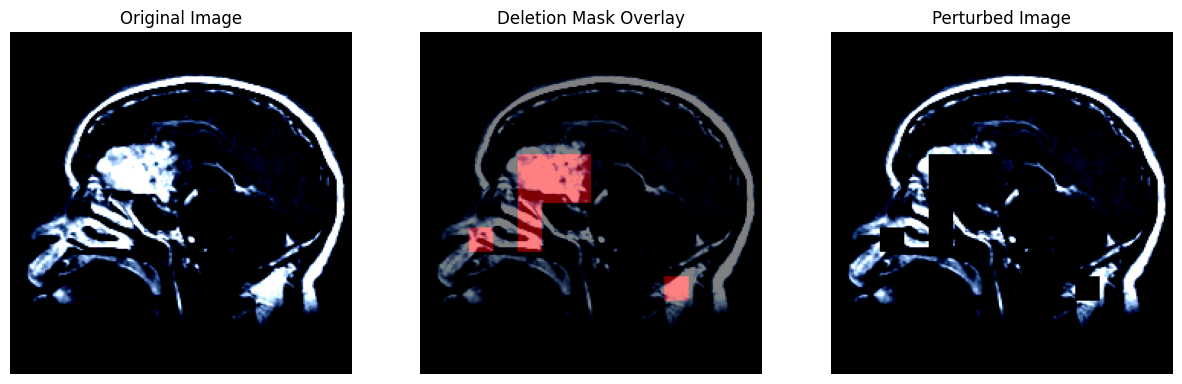

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Generate perturbation
perturbed_img, deletion_mask, patch_indices = perturb_topk_regions(
    image,                  # (1,3,H,W) or (3,H,W)
    saliency_t,             # torch tensor (H,W)
    k=10,                   # number of patches to perturb
    patch_size=16,
    perturbation="zero"
)

# Remove batch dim if needed
if perturbed_img.dim() == 4:
    perturbed_img = perturbed_img.squeeze(0)     # (3,H,W)

# Convert tensors → numpy for plotting
orig_np = image.squeeze(0).permute(1,2,0).cpu().numpy()
pert_np = perturbed_img.permute(1,2,0).cpu().numpy()

orig_np  = np.clip(orig_np, 0, 1)
pert_np  = np.clip(pert_np, 0, 1)

mask_np = deletion_mask.squeeze(0).cpu().numpy()  # (H,W)
mask_rgb = np.zeros_like(orig_np)
mask_rgb[...,0] = mask_np   # red channel = deleted regions


#  Plot
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(orig_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(orig_np)
plt.imshow(mask_rgb, cmap="Reds", alpha=0.5)
plt.title("Deletion Mask Overlay")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pert_np)
plt.title("Perturbed Image")
plt.axis("off")

plt.show()


### Visualising the Pertubation Sequence

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_perturbation_sequence(
    image,
    saliency,
    max_k=10,
    patch_size=16,
    perturbation="zero"
):
    """
    Visualises the sequence x, x1, x2, ..., xK where each x_k
    removes the k-th most salient patch.
    """

    # Ensure shapes
    if image.dim() == 3:
        image = image.unsqueeze(0)  # (1,C,H,W)

    # Convert saliency if numpy
    if isinstance(saliency, np.ndarray):
        saliency = torch.from_numpy(saliency).float()

    C, H, W = image.shape[-3:]
    device = image.device

    # Compute patch ranking (same as AOPC)
    if saliency.dim() == 4:
        sal = saliency[0, 0]
    else:
        sal = saliency.squeeze()

    n_h = H // patch_size
    n_w = W // patch_size

    sal_pooled = F.avg_pool2d(
        sal.unsqueeze(0).unsqueeze(0),
        kernel_size=patch_size,
        stride=patch_size
    ).reshape(n_h * n_w)

    sorted_indices = torch.argsort(sal_pooled, descending=True)

    # Prepare output
    perturbed_images = []
    masks = []

    current_img = image.clone()

    # Keep the original image first
    perturbed_images.append(image.squeeze(0).cpu())
    masks.append(torch.zeros((H,W)))

    #  Iterative perturbation
    for k in range(1, max_k + 1):
        idx = sorted_indices[k - 1].item()
        row = idx // n_w
        col = idx % n_w

        h_start = row * patch_size
        w_start = col * patch_size

        # apply deletion
        if perturbation == "zero":
            current_img[:, :, h_start:h_start+patch_size,
                        w_start:w_start+patch_size] = 0.0
        else:
            mean_val = image.mean()
            current_img[:, :, h_start:h_start+patch_size,
                        w_start:w_start+patch_size] = mean_val

        # save perturbed image (remove batch dim)
        perturbed_images.append(current_img.squeeze(0).cpu())

        # build mask
        mask = torch.zeros((H, W))
        mask[h_start:h_start+patch_size, w_start:w_start+patch_size] = 1.0
        masks.append(mask)

    # Plot grid
    cols = 5
    rows = int(np.ceil((max_k + 1) / cols))
    plt.figure(figsize=(15, rows*3))

    for i, (img_i, mask_i) in enumerate(zip(perturbed_images, masks)):
        plt.subplot(rows, cols, i+1)

        # convert to numpy
        img_np = img_i.permute(1,2,0).numpy()
        img_np = np.clip(img_np, 0, 1)

        mask_rgb = np.zeros_like(img_np)
        mask_rgb[...,0] = mask_i.numpy()  # red overlay

        # show image + deletion mask
        plt.imshow(img_np)
        plt.imshow(mask_rgb, cmap="Reds", alpha=0.4)
        if i == 0:
            plt.title("Original")
        else:
            plt.title(f"Step {i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Plot the pertubation sequence

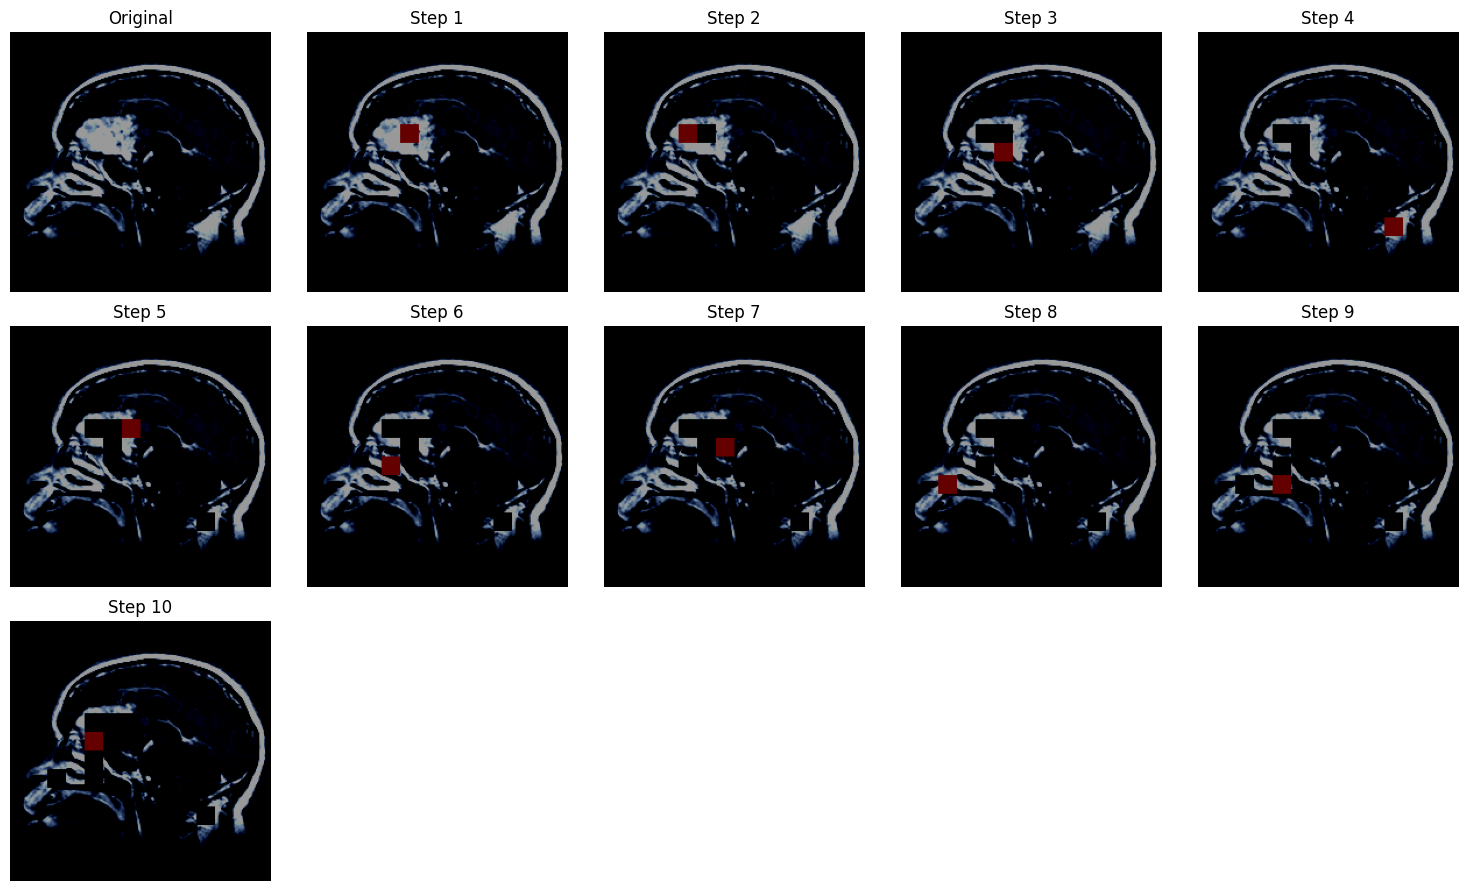

In [29]:
visualize_perturbation_sequence(
    image,
    saliency_t,        # Grad-CAM tensor (H,W)
    max_k=10,          # number of steps to visualise
    patch_size=16,
    perturbation="zero"
)


### Visualising the Confidence drop
We make a function that plots the drop in the 'confidence' or more technically the drop of the logit of our target class after perturbing the image.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_confidence_drop(curve, percentage=True):
    """
    Plots how the model's confidence changes as top-k salient patches
    are progressively removed.

    Args:
        curve: list of scores [f(x), f(x1), f(x2), ... f(xK)]
        percentage: True → plot % drop, False → absolute drop
    """

    curve = np.array(curve)
    f0 = curve[0]   # original score
    k_vals = np.arange(len(curve))  # 0..K

    # Compute drops
    abs_drop = f0 - curve
    pct_drop = 100 * abs_drop / f0

    if percentage:
        y_vals = pct_drop
        ylabel = "Confidence Drop (%)"
    else:
        y_vals = abs_drop
        ylabel = "Drop in Confidence (absolute)"

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(k_vals, y_vals, marker='o', linewidth=2)
    plt.fill_between(k_vals, y_vals, alpha=0.2)

    plt.title("Effect of Perturbing Most Relevant Patches")
    plt.xlabel("Number of Perturbed Patches (k)")
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)

    plt.xticks(k_vals)
    plt.show()

    return y_vals


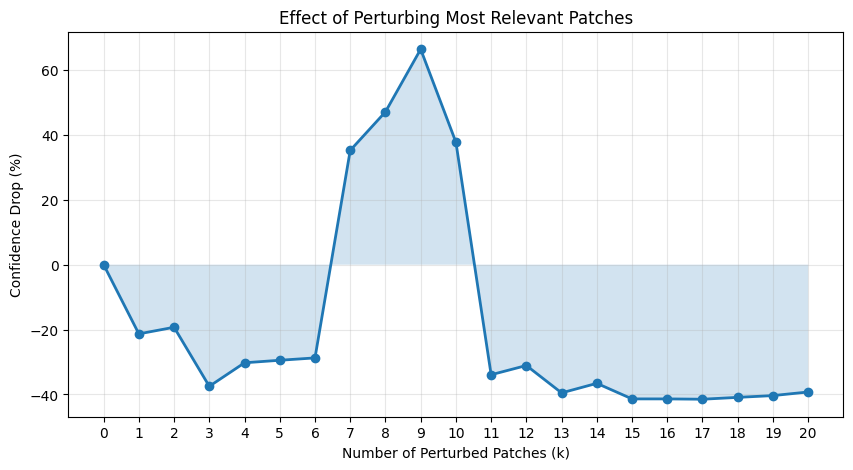

array([  0.        , -21.32737897, -19.29309015, -37.49274551,
       -30.23742026, -29.46165441, -28.7337817 ,  35.21236567,
        47.09190416,  66.39541999,  37.74989139, -33.92397599,
       -31.07763199, -39.51553187, -36.57411943, -41.36873715,
       -41.37055289, -41.46882208, -40.89727981, -40.35006837,
       -39.2398275 ])

In [31]:
plot_confidence_drop(curve, percentage=True)

The MoRF confidence-drop curve shows that removing the first 10 most salient patches causes negligible change in the model’s confidence (<1%). This indicates that the highest-ranked Grad-CAM regions are not strongly tied to the classifier’s decision. At patch 11, we observe a sudden ~35% confidence drop, suggesting that Grad-CAM mis-ranked this region lower than its true importance. Only after a substantial number of patches are removed (k>17) does the model’s confidence collapse (60% drop).

This behaviour is consistent with findings from the Sanity Checks for Saliency Maps paper: Grad-CAM produces smooth visual explanations but is not strictly faithful as an importance ranking. The model appears to rely on distributed evidence across many moderately important regions rather than a single concentrated hotspot.